## Analysis of PLIER latent space representations vs. other methods

In [5]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import config as cfg

In [15]:
z_dims = [10, 20, 50, 100, 200]
models_dir = os.path.join(cfg.models_dir, 'canonical_pathways', 'ensemble_z_matrices')
df = None
for z_dim in z_dims:
    weights_pattern = os.path.join(os.path.abspath(models_dir),
                                   'components_{}'.format(z_dim),
                                   '*_weight_matrix.tsv.gz')
    for fname in glob.glob(weights_pattern):
        short_fname = os.path.split(fname)[-1]
        algorithm = short_fname.split('_')[0]
        seed = int(short_fname.split('_')[1])
        signal = ('shuffled' if 'shuffled' in short_fname else 'signal')
        weights = pd.read_csv(fname, sep='\t').to_numpy()
        num_zeros = np.count_nonzero(weights==0)
        sparsity = num_zeros / weights.size
        weights_df = pd.DataFrame({
            'algorithm': [algorithm],
            'z_dim': [z_dim],
            'signal': [signal],
            'seed': [seed],
            'num_zeros': [num_zeros],
            'sparsity': [sparsity]
        })
        if df is not None:
            df = pd.concat((df, weights_df))
        else:
            df = weights_df
df.reset_index(inplace=True)
df.head()

,index,algorithm,z_dim,signal,seed,num_zeros,sparsity
0,0,nmf,10,signal,259178,20601,0.257480
1,0,pca,10,shuffled,131932,0,0.000000
2,0,plier,10,signal,259178,21047,0.559166
3,0,plier,10,signal,131932,21138,0.561583
4,0,nmf,10,shuffled,671155,20801,0.259980


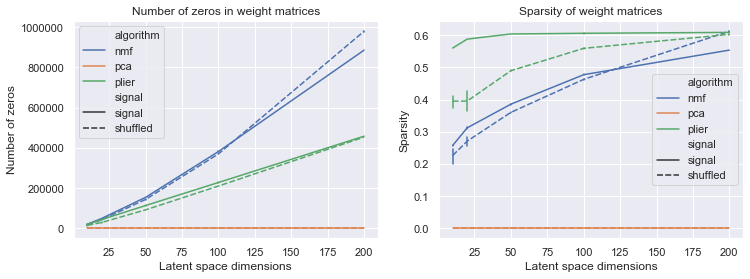

In [17]:
sns.set()
fig, axarr = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
sns.lineplot(data=df, x='z_dim', y='num_zeros', hue='algorithm',
             style='signal', err_style='bars', ax=axarr[0])
axarr[0].set_title('Number of zeros in weight matrices')
axarr[0].set_xlabel('Latent space dimensions')
axarr[0].set_ylabel('Number of zeros')
sns.lineplot(data=df, x='z_dim', y='sparsity', hue='algorithm',
             style='signal', err_style='bars', ax=axarr[1])
axarr[1].set_title('Sparsity of weight matrices')
axarr[1].set_xlabel('Latent space dimensions')
axarr[1].set_ylabel('Sparsity')
plt.show()